In [1]:
# import packages needed
import os
import json
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from matplotlib import figure
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mapclassify

# 1. Load the data

## 1.1 London Borough Map

<AxesSubplot:>

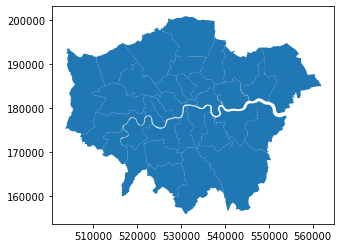

In [2]:
# load the data
boros = gpd.read_file('https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/Boroughs.gpkg?raw=true')
boros.plot()

## 1.2 Inside Airbnb

In [3]:
# load the data and select the columns needed
cols = ['id','name','price','neighbourhood_cleansed','latitude','longitude','property_type','room_type']
url_airbnb = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz'
df_airbnb = pd.read_csv(url_airbnb, compression='gzip', usecols=cols)

df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      67903 non-null  int64  
 1   name                    67879 non-null  object 
 2   neighbourhood_cleansed  67903 non-null  object 
 3   latitude                67903 non-null  float64
 4   longitude               67903 non-null  float64
 5   property_type           67903 non-null  object 
 6   room_type               67903 non-null  object 
 7   price                   67903 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 4.1+ MB


### Data Cleaning

In [4]:
# clean the data
df_airbnb['price'] = df_airbnb.price.str.replace('$','').str.replace(',','').astype(float)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude.isna())|(df_airbnb.longitude.isna()))].index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude < 40)|(df_airbnb.longitude > 1))].index, axis=0, inplace=True)

df_airbnb.info

<ipython-input-4-38418f533085>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb['price'] = df_airbnb.price.str.replace('$','').str.replace(',','').astype(float)


<bound method DataFrame.info of              id                                               name  \
0         13913                Holiday London DB Room Let-on going   
1         15400                Bright Chelsea  Apartment. Chelsea!   
2         17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1   
3         17506  Boutique Chelsea/Fulham Double bed 5-star ensuite   
4         24328  Battersea bedroom & studio, parking, shared ga...   
...         ...                                                ...   
67898  52708661                          Immaculate room available   
67899  52710377      Double studio apartment in Lancaster Gate (14   
67900  52711482  4 Bedroom House in The Tonsleys (Wandsworth Town)   
67901  52712635                           Faveo Dartford Apartment   
67902  52717191                       Double bedroom in 2-bed flat   

       neighbourhood_cleansed   latitude  longitude  \
0                   Islington  51.568610  -0.112700   
1      Kensington

## 1.3 Rental

In [5]:
# load the data and select the columns needed
cols_rental = ['Borough','Bedroom_Category','Count_of_rents','Mean']
url_rental = 'https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/london_rental_statistics.xlsx?raw=true'
df_rental = pd.read_excel(url_rental, sheet_name = 0, usecols = cols_rental)

df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Borough           198 non-null    object 
 1   Bedroom_Category  198 non-null    object 
 2   Count_of_rents    188 non-null    float64
 3   Mean              188 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.3+ KB


In [6]:
df_rental.sample(3, random_state=42)

,Borough,Bedroom_Category,Count_of_rents,Mean
65,Greenwich,Four or More Bedrooms,50.0,2079.0
114,Kensington and Chelsea,Room,NaN,NaN
16,Bexley,Three Bedrooms,200.0,1294.0


### Data Cleaning

In [7]:
# clean the data
df_rental.drop(index = df_rental[df_rental.Count_of_rents.isna()].index, axis=0, inplace=True)
df_rental.drop(index = df_rental[df_rental.Mean.isna()].index, axis = 0, inplace=True)

print(df_rental.shape)
df_rental.sample(3, random_state=42)

(188, 4)


,Borough,Bedroom_Category,Count_of_rents,Mean
193,Westminster,Studio,220.0,1315.0
171,Sutton,Two Bedrooms,560.0,1171.0
19,Brent,Studio,120.0,904.0


# 2. Basic Analysis（Descriptive statistics）

## 2.1 Counts of Airbnb Listings

In [8]:
# set the data in one group
airbnb_data = df_airbnb.groupby(['neighbourhood_cleansed'])
print(type(airbnb_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [9]:
# count the listings in each borough
count_series = airbnb_data.neighbourhood_cleansed.apply(pd.value_counts)
count_boros = pd.Series(count_series ,name='count')
count_boros

neighbourhood_cleansed                        
Barking and Dagenham    Barking and Dagenham       390
Barnet                  Barnet                    1504
Bexley                  Bexley                     273
Brent                   Brent                     1908
Bromley                 Bromley                    543
Camden                  Camden                    4619
City of London          City of London             356
Croydon                 Croydon                   1055
Ealing                  Ealing                    1575
Enfield                 Enfield                    571
Greenwich               Greenwich                 1472
Hackney                 Hackney                   5178
Hammersmith and Fulham  Hammersmith and Fulham    3036
Haringey                Haringey                  1890
Harrow                  Harrow                     430
Havering                Havering                   255
Hillingdon              Hillingdon                 577
Hounslow          

### Histogram of Counts

<AxesSubplot:xlabel='neighbourhood_cleansed', ylabel='count'>

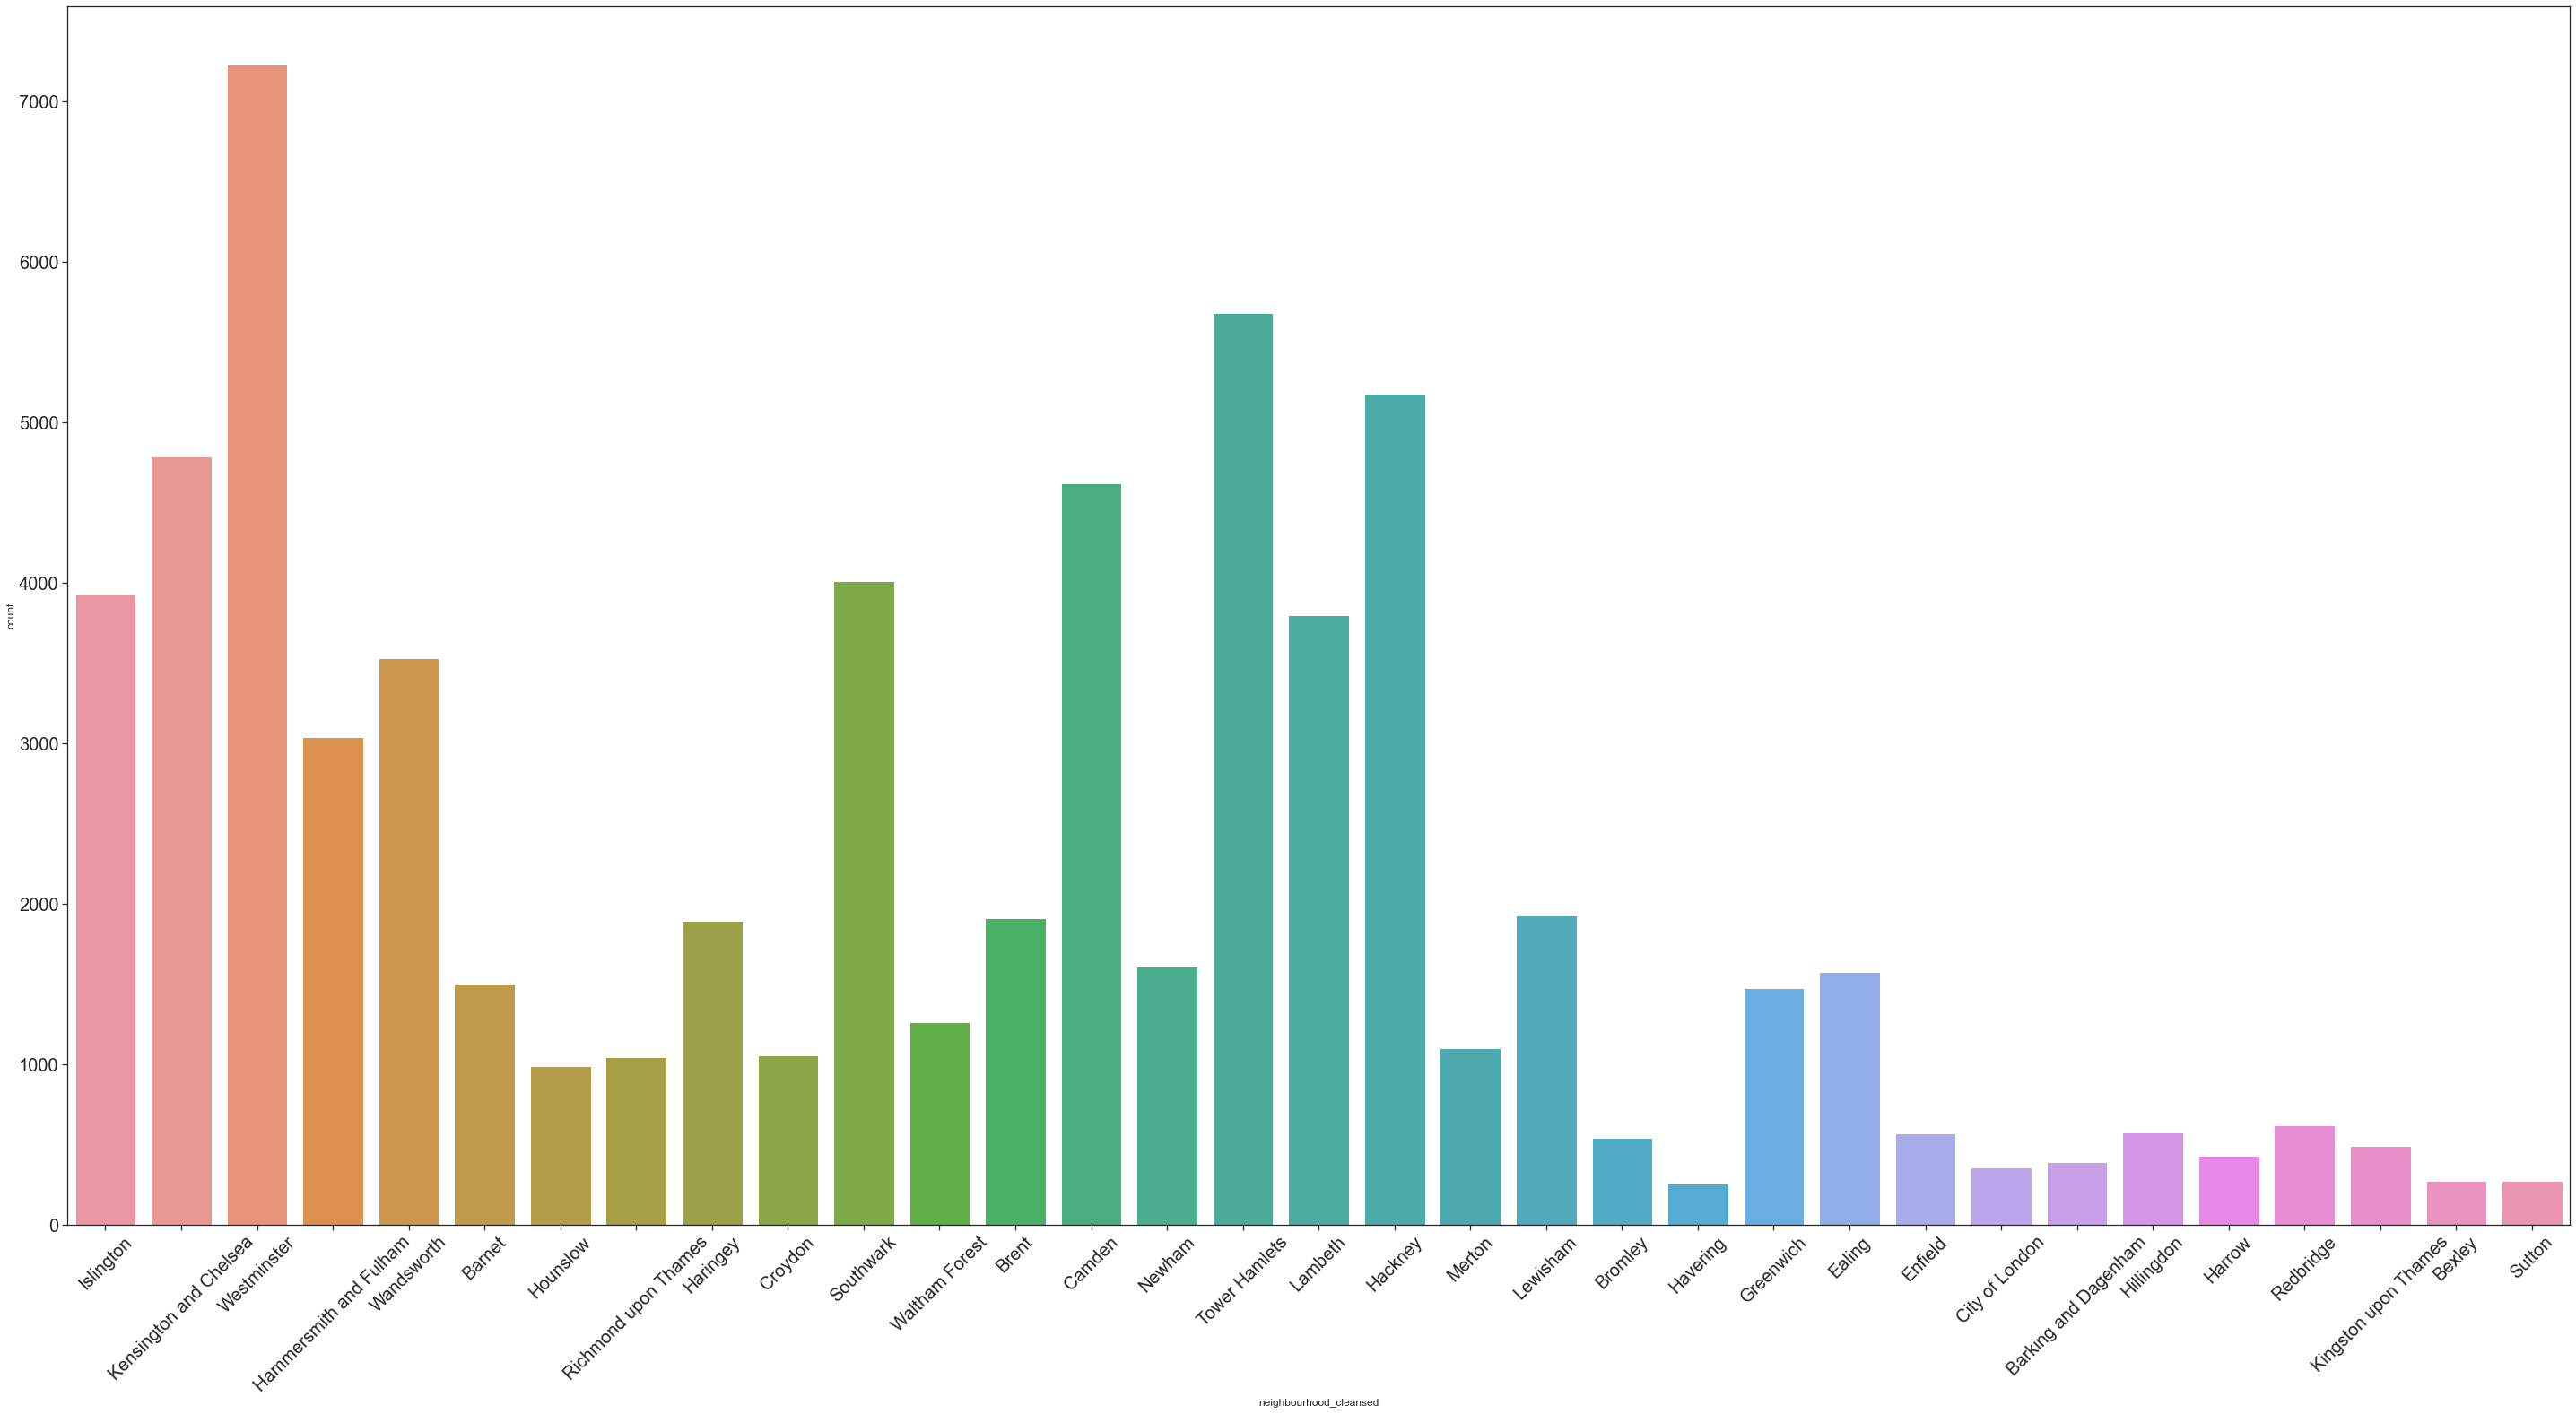

In [10]:
# plot the counts of listings in each borough
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(50, 25))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.xticks(rotation=45)

sns.countplot(x="neighbourhood_cleansed", data = df_airbnb)

## 2.2 Boxplot of the Room Type of Airbnb Listings

(0.0, 500.0)

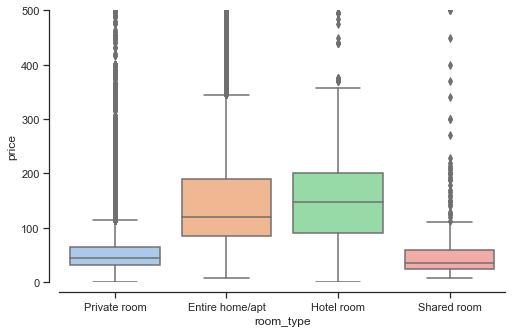

In [11]:
# boxplot based on room type of airbnb
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
sns.boxplot(y = df_airbnb.price, x = df_airbnb.room_type)
sns.despine(offset=10)
ax.set_ylim([0,500])

# 3. Mapping

## 3.1 Airbnb Distributions

### Add Geometry and Reproject

In [12]:
# Convert the df into a GeoDataFrame named gdf
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude, crs='epsg:4326'))
gdf_airbnb = gdf_airbnb.to_crs('epsg:27700')

### Add LA Names to Data

In [13]:
# Associate LA (Local Authority) names to the listings using a spatial join
gdf_boros = gpd.sjoin(gdf_airbnb, boros, op='within', how='left')
print(gdf_boros.columns.values)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


['id' 'name' 'neighbourhood_cleansed' 'latitude' 'longitude'
 'property_type' 'room_type' 'price' 'geometry' 'index_right' 'NAME'
 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [14]:
print(gdf_boros.shape)
gdf_boros.sample(3, random_state=42)[['id','name','NAME']]

(67903, 15)


,id,name,NAME
53662,42409608,Cosy two bedroom home full of character,Merton
49155,39318693,Frills-free yet Clean and Comfortable Bedroom,Tower Hamlets
36922,29555250,Unmissable Luxurious Mews House in Central London,Westminster


### Tidy Up

In [15]:
gdf_boros.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_boros.NAME.unique()

array(['Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Wandsworth', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Croydon', 'Southwark',
       'Waltham Forest', 'Brent', 'Camden', 'Newham', 'Tower Hamlets',
       'Lambeth', 'Hackney', 'Merton', 'Lewisham', 'Bromley', 'Havering',
       'Greenwich', 'Ealing', 'Enfield', 'City of London',
       'Barking and Dagenham', 'Hillingdon', 'Harrow', 'Redbridge',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

In [16]:
gdf_airbnb[gdf_boros.NAME.isna()][['id','name']]

,id,name
3811,4255997,Northwood nr Nato 2 double bedr - patio and ga...
23571,20021442,Large Private 1 Bedroom Apartment in Battersea
30638,24341533,Hampton Suites One Bedroom Apartment
66490,52108511,"Luxury 2 bed Apartment, Balcony Pool Gym Chigwell"
66840,52240064,GR-2 a double Room with - En-suite
67014,52320959,"Warm family home, a place for families on the go!"
67326,52461502,Chigwell Luxury 3 bed apartment in gated commu...
67441,52513179,2 Bedroom Luxury Riverside Apartment
67443,52513622,"5 Star Luxury Apartment, Pool/Spa/Gym, Zone 1"
67591,52577592,Cosy double room for 1.


In [17]:
# drop problematic results
gdf_boros.drop(index=gdf_airbnb[gdf_boros.NAME.isna()].index, axis=1, inplace=True)
print(gdf_boros.shape)

(67891, 11)


### Check Results

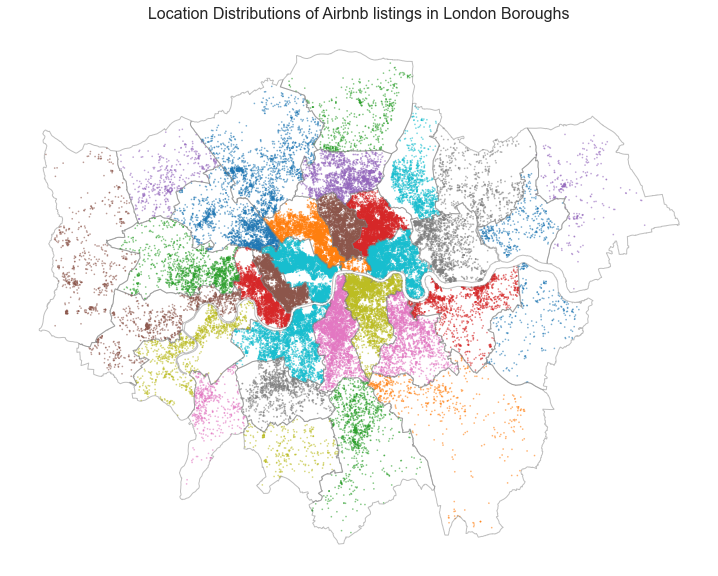

In [18]:
# plot the locations of airbnb listings
def map_airbnb_loc():
    
    ax = gdf_boros.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(16,10))
    boros.plot(ax=ax, edgecolor='0.5', facecolor='None', alpha=0.5);
    ax.axis('off')

    ax.set_title('Location Distributions of Airbnb listings in London Boroughs', fontdict={
             'fontsize': '16', 'fontweight': '1'})
    
map_airbnb_loc()

### Plot the Counts of Airbnb Listings

In [19]:
# merge the data
boros_airbnb_count = pd.merge(boros, count_boros, left_on = 'NAME', right_on = 'neighbourhood_cleansed', how = 'inner')
boros_airbnb_count.sample(3, random_state=42)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,count
31,Barking and Dagenham,E09000002,3779.934,169.150,F,"MULTIPOLYGON (((543905.400 183199.100, 543905....",390
15,Enfield,E09000010,8220.025,0.000,F,"MULTIPOLYGON (((531023.500 200933.600, 531039....",571
26,Tower Hamlets,E09000030,2157.501,179.707,T,"MULTIPOLYGON (((533387.600 180516.400, 533389....",5679


In [20]:
boros_airbnb_count.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-21-fcffabb65709>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


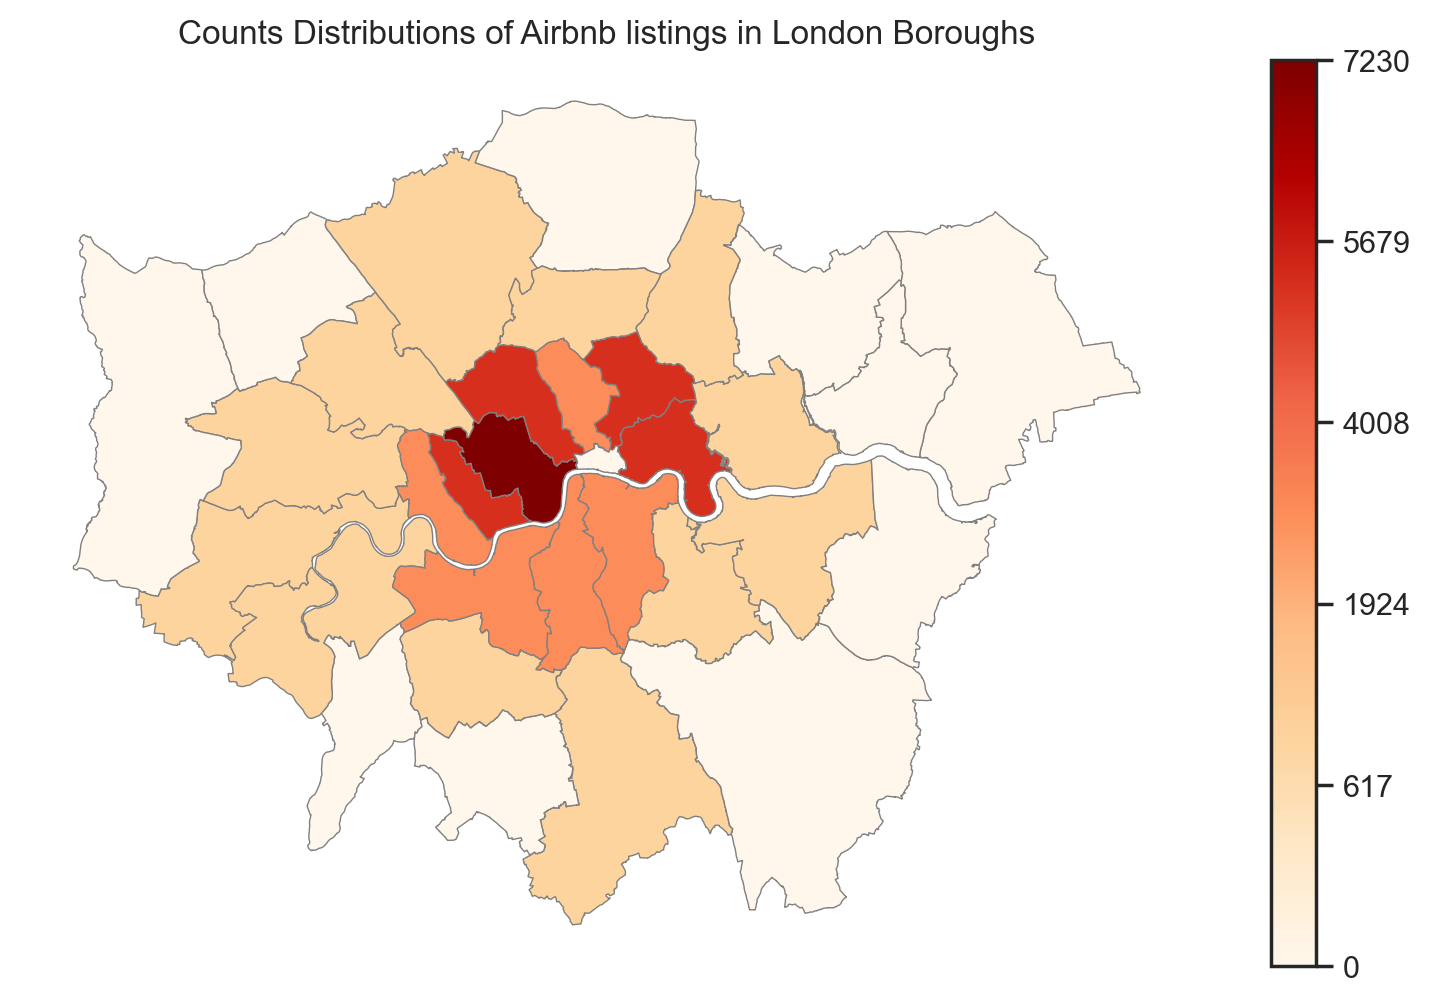

In [21]:
def map_airbnb_counts():
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)

    boros_airbnb_count.plot(column='count', cmap='OrRd', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_airbnb_count['count'], 5).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)
    
    ax.set_title('Counts Distributions of Airbnb listings in London Boroughs', fontdict={
             'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_counts()

## 3.2 Average price of Airbnb

In [22]:
# set the data in one group
gdf_data = gdf_boros.groupby(['NAME'])
print(type(gdf_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [23]:
# calculate the mean price of airbnb by borough
airbnb_price_mean = gdf_data.price.mean()
airbnb_price_mean

NAME
Barking and Dagenham       76.228205
Barnet                    132.564495
Bexley                     67.400735
Brent                     125.370545
Bromley                    79.121547
Camden                    156.061052
City of London            241.044944
Croydon                    67.545024
Ealing                     91.391746
Enfield                    72.527145
Greenwich                 136.095918
Hackney                   103.768250
Hammersmith and Fulham    141.785832
Haringey                   96.059259
Harrow                     77.497674
Havering                   83.254902
Hillingdon                 92.024348
Hounslow                  111.526795
Islington                 143.295825
Kensington and Chelsea    209.909566
Kingston upon Thames      103.535787
Lambeth                   101.165613
Lewisham                   90.135135
Merton                    121.448683
Newham                     91.285803
Redbridge                  79.078049
Richmond upon Thames      137.435

In [24]:
# merge the data
boros_airbnb_price = boros.merge(airbnb_price_mean, how = 'left', on = 'NAME')
boros_airbnb_price.sample(3, random_state=42)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,price
31,Barking and Dagenham,E09000002,3779.934,169.150,F,"MULTIPOLYGON (((543905.400 183199.100, 543905....",76.228205
15,Enfield,E09000010,8220.025,0.000,F,"MULTIPOLYGON (((531023.500 200933.600, 531039....",72.527145
26,Tower Hamlets,E09000030,2157.501,179.707,T,"MULTIPOLYGON (((533387.600 180516.400, 533389....",106.772495


In [25]:
# tidy up
boros_airbnb_price.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-26-82e2aaa38212>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


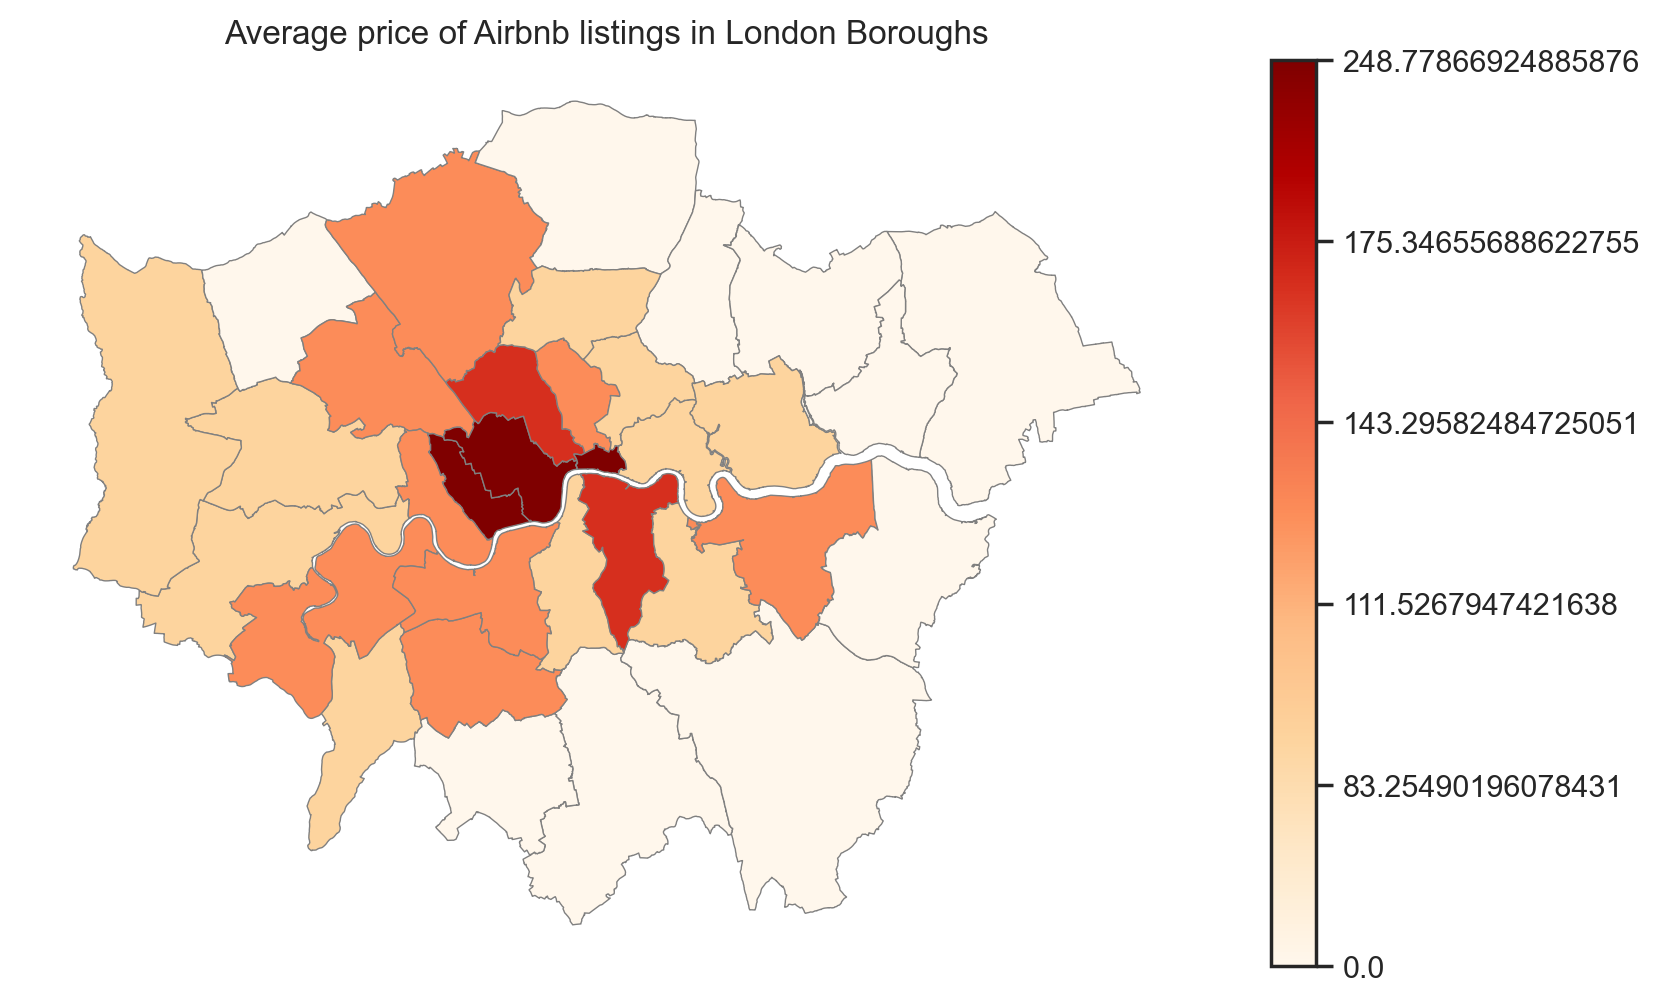

In [26]:
def map_airbnb_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
    
    boros_airbnb_price.plot(column='price', cmap='OrRd', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_airbnb_price['price'], 5).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average price of Airbnb listings in London Boroughs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_price()

## 3.3 Average price of Rental Market

In [27]:
# merge the data
boros_rental = pd.merge(boros, df_rental, left_on = 'NAME', right_on = 'Borough', how = 'inner')
boros_rental.sample(3, random_state=42)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,Borough,Bedroom_Category,Count_of_rents,Mean
183,Barking and Dagenham,E09000002,3779.934,169.150,F,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Barking and Dagenham,Three Bedrooms,150.0,1438.0
162,Hackney,E09000012,1904.902,0.000,T,"MULTIPOLYGON (((531928.400 187801.500, 531935....",Hackney,Studio,60.0,1031.0
18,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967....",Hounslow,Room,70.0,602.0


In [28]:
# tidy up
boros_rental.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-29-aa8b1ff85339>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  legend = cbar.ax.set_yticklabels(bins)


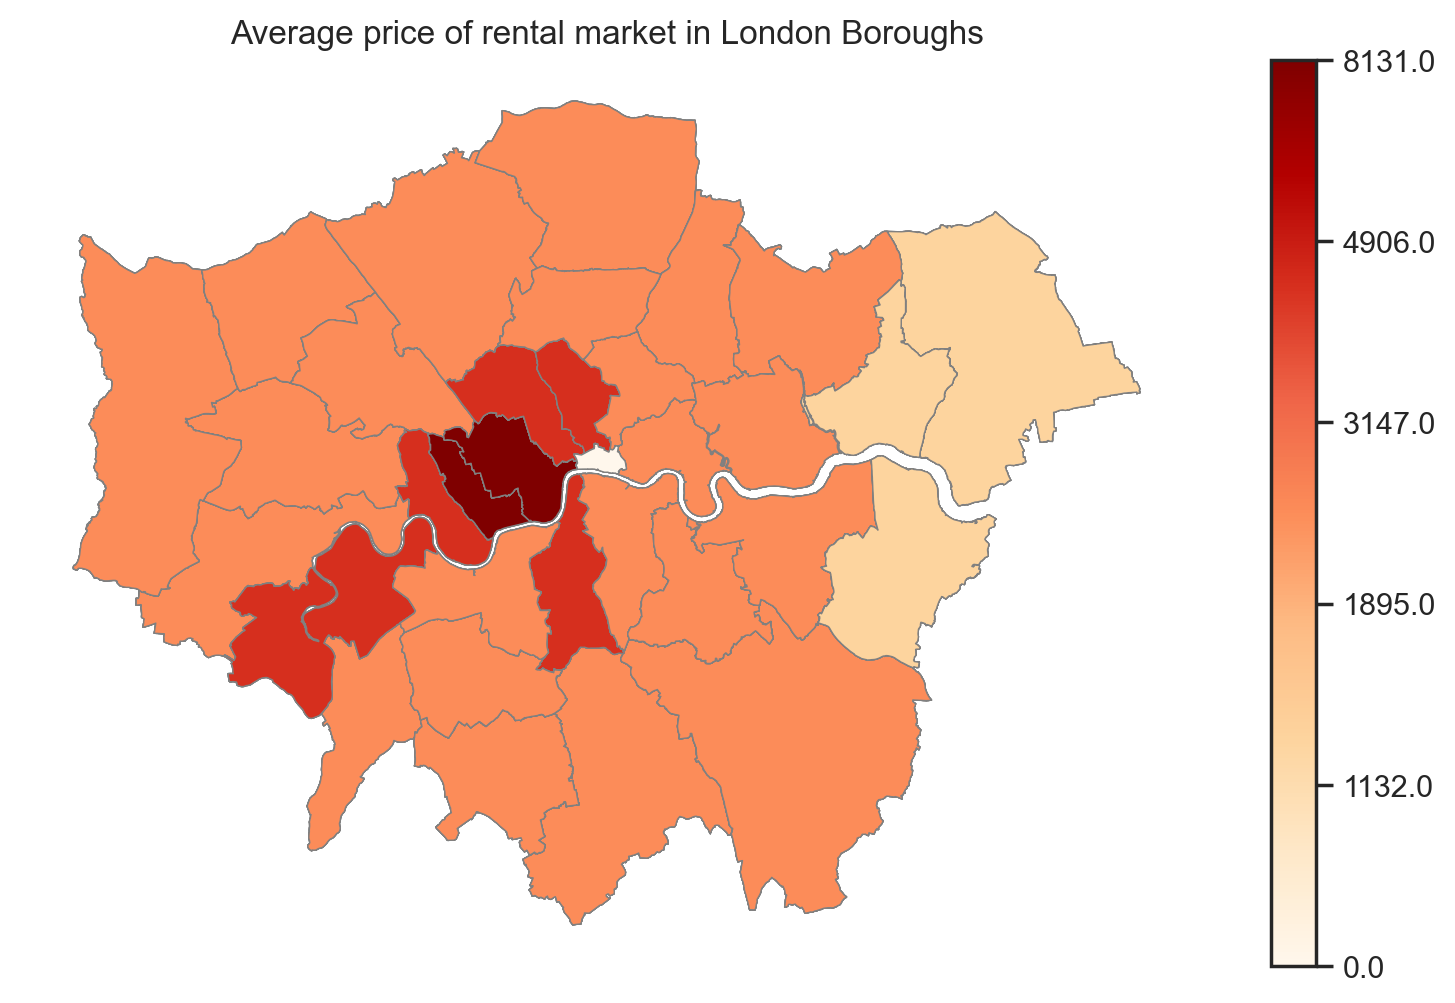

In [29]:
def map_rental_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)

    boros_rental.plot(column='Mean', cmap='OrRd', scheme='FisherJenks',
                      linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_rental['Mean'], 5).bins
    bins = np.insert(bins, 0, 0)
    legend = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average price of rental market in London Boroughs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_rental_price()

# 4. Regression

## 4.1 Average Price of Rental Market & Counts of Airbnb Listings

In [30]:
# merge the data of rental and airbnb counts
boros_rental_airbnb_count = boros_rental.merge(boros_airbnb_count, how = 'left', on = 'NAME')
boros_rental_airbnb_count.sample(3, random_state=42)

,NAME,GSS_CODE_x,geometry_x,Borough,Bedroom_Category,Count_of_rents,Mean,GSS_CODE_y,geometry_y,count
183,Barking and Dagenham,E09000002,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Barking and Dagenham,Three Bedrooms,150.0,1438.0,E09000002,"MULTIPOLYGON (((543905.400 183199.100, 543905....",390
162,Hackney,E09000012,"MULTIPOLYGON (((531928.400 187801.500, 531935....",Hackney,Studio,60.0,1031.0,E09000012,"MULTIPOLYGON (((531928.400 187801.500, 531935....",5178
18,Hounslow,E09000018,"MULTIPOLYGON (((521975.800 178100.000, 521967....",Hounslow,Room,70.0,602.0,E09000018,"MULTIPOLYGON (((521975.800 178100.000, 521967....",989


### Linear Regression

In [31]:
# set the average price of airbnb as x value
# set the average price of rental market as y value
x_values = boros_rental_airbnb_count['count']
y_values = boros_rental_airbnb_count['Mean']

In [32]:
x_values

0      489
1      489
2      489
3      489
4      489
      ... 
183    390
184    390
185    356
186    356
187    356
Name: count, Length: 188, dtype: int64

In [33]:
y_values

0       506.0
1       842.0
2      1102.0
3      1374.0
4      1731.0
        ...  
183    1438.0
184    1695.0
185       0.0
186    2050.0
187       0.0
Name: Mean, Length: 188, dtype: float64

In [34]:
import statsmodels.api as sms

X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()

print(regression_model_b.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     45.23
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           2.09e-10
Time:                        01:56:00   Log-Likelihood:                -1550.1
No. Observations:                 188   AIC:                             3104.
Df Residuals:                     186   BIC:                             3111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1081.9380    101.172     10.694      0.0

In [35]:
p_value    = regression_model_b.f_pvalue
R_squared  = regression_model_b.rsquared
print("R_squared  =", R_squared)
print("p_value    =", p_value)

R_squared  = 0.1956194086031866
p_value    = 2.0882756974009688e-10


### Log Regression

In [36]:
import statsmodels.formula.api as sm

regression_model_log = sm.ols(formula="Mean ~ count.apply(np.log)", data = boros_rental_airbnb_count).fit()
print(regression_model_log.params)

Intercept             -1496.728790
count.apply(np.log)     429.044811
dtype: float64


In [37]:
print(regression_model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     37.21
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           6.01e-09
Time:                        01:56:00   Log-Likelihood:                -1553.4
No. Observations:                 188   AIC:                             3111.
Df Residuals:                     186   BIC:                             3117.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1496.7288    

In [38]:
p_value_log    = regression_model_log.f_pvalue
R_squared_log  = regression_model_log.rsquared
print("R_squared_log  =", R_squared_log)
print("p_value_log    =", p_value_log)

R_squared_log  = 0.16670330470649242
p_value_log    = 6.013455121331003e-09


## 4.2 Average Price of Rental Market & Average Price of Airbnb Listings

In [39]:
# merge the data of rental and airbnb
boros_rental_airbnb_price = pd.merge(boros_rental, airbnb_price_mean, left_on = 'Borough', right_on = 'NAME', how = 'inner')
boros_rental_airbnb_price.sample(3, random_state=42)

,NAME,GSS_CODE,geometry,Borough,Bedroom_Category,Count_of_rents,Mean,price
183,Barking and Dagenham,E09000002,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Barking and Dagenham,Three Bedrooms,150.0,1438.0,76.228205
162,Hackney,E09000012,"MULTIPOLYGON (((531928.400 187801.500, 531935....",Hackney,Studio,60.0,1031.0,103.768250
18,Hounslow,E09000018,"MULTIPOLYGON (((521975.800 178100.000, 521967....",Hounslow,Room,70.0,602.0,111.526795


### Linear Regression

In [40]:
# set the average price of airbnb as x value
# set the average price of rental market as y value
x_values = boros_rental_airbnb_price['price']
y_values = boros_rental_airbnb_price['Mean']

In [41]:
x_values

0      103.535787
1      103.535787
2      103.535787
3      103.535787
4      103.535787
          ...    
183     76.228205
184     76.228205
185    241.044944
186    241.044944
187    241.044944
Name: price, Length: 188, dtype: float64

In [42]:
y_values

0       506.0
1       842.0
2      1102.0
3      1374.0
4      1731.0
        ...  
183    1438.0
184    1695.0
185       0.0
186    2050.0
187       0.0
Name: Mean, Length: 188, dtype: float64

In [43]:
X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()

print(regression_model_b.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     34.23
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           2.17e-08
Time:                        01:56:00   Log-Likelihood:                -1554.7
No. Observations:                 188   AIC:                             3113.
Df Residuals:                     186   BIC:                             3120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        534.9275    192.914      2.773      0.0

In [44]:
p_value    = regression_model_b.f_pvalue
R_squared  = regression_model_b.rsquared
print("R_squared  =", R_squared)
print("p_value    =", p_value)

R_squared  = 0.1554182305910059
p_value    = 2.171524133736069e-08


### Log Regression

In [45]:
regression_model_log = sm.ols(formula="Mean ~ price.apply(np.log)", data = boros_rental_airbnb_price).fit()
print(regression_model_log.params)

Intercept             -4006.316238
price.apply(np.log)    1196.846305
dtype: float64


In [46]:
print(regression_model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     33.73
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           2.70e-08
Time:                        01:56:00   Log-Likelihood:                -1554.9
No. Observations:                 188   AIC:                             3114.
Df Residuals:                     186   BIC:                             3120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -4006.3162    

In [47]:
p_value_log    = regression_model_log.f_pvalue
R_squared_log  = regression_model_log.rsquared
print("R_squared_log  =", R_squared_log)
print("p_value_log    =", p_value_log)

R_squared_log  = 0.15349360398741407
p_value_log    = 2.6992353795885254e-08
